#### Importing Required Libraries

In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, recall_score, precision_score,make_scorer,classification_report,roc_curve
import seaborn as sns
import xgboost as xgb
np.random.seed(42)

#### Importing The given Data

In [206]:
train = pd.read_csv('train.csv')
campaign_df = pd.read_csv('campaign_data.csv')
coupons = pd.read_csv('coupon_item_mapping.csv')
demographics = pd.read_csv('customer_demographics.csv')
transactions = pd.read_csv('customer_transaction_data.csv')
item_df = pd.read_csv('item_data.csv')

In [207]:
transactions.shape

(1324566, 7)

#### Creating New feature actual price in transactions data

In [208]:
transactions['actual_price'] = transactions['selling_price'] - transactions['other_discount'] - transactions['coupon_discount']

In [209]:
transactions

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,actual_price
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0,45.95
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0,67.32
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0,120.75
3,2012-01-02,1501,33647,1,67.32,0.00,0.0,67.32
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0,99.38
...,...,...,...,...,...,...,...,...
1324561,2013-06-30,1129,2777,1,284.60,-71.24,0.0,355.84
1324562,2013-06-30,1129,2953,4,42.74,-28.50,0.0,71.24
1324563,2013-06-30,1129,2971,6,64.12,-42.74,0.0,106.86
1324564,2013-06-30,1129,46984,1,95.82,0.00,0.0,95.82


#### Filling NULL Values in Customer Demographics data

In [210]:
demographics['no_of_children'].fillna('99999',inplace=True)
demographics['marital_status'].fillna('other',inplace=True)

In [211]:
demographics

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,99999,4
1,6,46-55,Married,0,2,99999,5
2,7,26-35,other,0,3,1,3
3,8,26-35,other,0,4,2,6
4,10,46-55,Single,0,1,99999,5
...,...,...,...,...,...,...,...
755,1577,36-45,other,0,2,99999,5
756,1578,46-55,Married,0,3,1,6
757,1579,46-55,other,0,1,99999,4
758,1580,26-35,other,0,2,99999,5


### Feature engineering

In [212]:
cat_agg=['count','nunique']
num_agg=['min','max','mean','sum']
agg_col={'quantity':num_agg, 'selling_price':num_agg, 'other_discount':num_agg,'coupon_discount':num_agg,
       'brand':cat_agg, 'brand_type':cat_agg, 'category':cat_agg, 'age_range':cat_agg, 'marital_status':cat_agg,
    'rented':cat_agg, 'family_size':cat_agg, 'no_of_children':cat_agg, 'income_bracket':cat_agg}

In [213]:
transactions = transactions.merge(item_df,how='left',on='item_id').merge(demographics,how='left',on='customer_id').groupby('customer_id').agg(agg_col).reset_index()

In [214]:
transactions

customer_id quantity                            selling_price           \
                      min    max        mean     sum           min      max   
0              1        1      5    1.170802    1227         12.11   445.25   
1              2        1      5    1.131265     474         14.25   640.80   
2              3        1   6949   11.578723    8163          8.90   862.00   
3              4        1      5    1.272727     280         14.25  1330.05   
4              5        1  14638  117.869949   93353         12.11  1485.35   
...          ...      ...    ...         ...     ...           ...      ...   
1577        1578        1  15214  136.790549  107107         13.54  1531.66   
1578        1579        1     12    1.511188    1756         13.54  1045.09   
1579        1580        1  13142   38.689981   20467          3.56  1020.16   
1580        1581        1  23972  282.318812  142571          7.12  2030.34   
1581        1582        1  22471  216.069412  183659         13.89  2240.50   

                            other_discount  ... marital_status         rented  \
            mean        sum            min  ...          count nunique  count   
0      94.001842   98513.93        -372.23  ...           1048       1   1048   
1     102.864033   43100.03        -312.03  ...              0       0      0   
2     103.617404   73050.27        -463.06  ...              0       0      0   
3     154.423727   33973.22        -390.04  ...              0       0      0   
4     130.827146  103615.10        -216.21  ...              0       0      0   
...          ...        ...            ...  ...            ...     ...    ...   
1577  104.750268   82019.46        -514.35  ...            783       1    783   
1578  125.954294  146358.89        -463.06  ...           1162       1   1162   
1579  112.336673   59426.10        -288.88  ...            529       1    529   
1580  113.925228   57532.24        -213.72  ...            505       1    505   
1581  138.742871  117931.44        -640.80  ...              0       0      0   

             family_size         no_of_children         income_bracket          
     nunique       count nunique          count nunique          count nunique  
0          1        1048       1           1048       1           1048       1  
1          0           0       0              0       0              0       0  
2          0           0       0              0       0              0       0  
3          0           0       0              0       0              0       0  
4          0           0       0              0       0              0       0  
...      ...         ...     ...            ...     ...            ...     ...  
1577       1         783       1            783       1            783       1  
1578       1        1162       1           1162       1           1162       1  
1579       1         529       1            529       1            529       1  
1580       1         505       1            505       1            505       1  
1581       0           0       0              0       0              0       0  

[1582 rows x 35 columns]

In [215]:
cat_agg=['count','nunique']
num_agg=['min','max','mean','sum']
agg_col={'brand':cat_agg, 'brand_type':cat_agg, 'category':cat_agg}

In [216]:
coupons = coupons.merge(item_df,how='left',on='item_id').groupby('coupon_id').agg(agg_col).reset_index()

In [217]:
coupons

coupon_id brand         brand_type         category        
               count nunique      count nunique    count nunique
0            1    39       3         39       1       39       2
1            2     2       1          2       1        2       1
2            3    17       2         17       1       17       1
3            4    24       1         24       1       24       1
4            5     7       1          7       1        7       1
...        ...   ...     ...        ...     ...      ...     ...
1111      1112     6       1          6       1        6       1
1112      1113    15       1         15       1       15       1
1113      1114     3       1          3       1        3       1
1114      1115     7       1          7       1        7       1
1115      1116     2       1          2       1        2       1

[1116 rows x 7 columns]

### Merging The Data

In [218]:
def merged_df(df):
    df = df.merge(campaign_df,how='left',on='campaign_id')
    df = df.merge(coupons,how='left',on='coupon_id')
    df = df.merge(transactions,how='left',on='customer_id')
    return df

In [219]:
train_df = merged_df(train.copy())
train_df

/nfs/cms/mtech18/mangesh.kshirsagar/.conda/envs/Home/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/nfs/cms/mtech18/mangesh.kshirsagar/.conda/envs/Home/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,"('brand', 'count')_x","('brand', 'nunique')_x",...,"(marital_status, count)","(marital_status, nunique)","(rented, count)","(rented, nunique)","(family_size, count)","(family_size, nunique)","(no_of_children, count)","(no_of_children, nunique)","(income_bracket, count)","(income_bracket, nunique)"
0,1,13,27,1053,0,X,19/05/13,05/07/13,125,2,...,310,1,310,1,310,1,310,1,310,1
1,2,13,116,48,0,X,19/05/13,05/07/13,3,1,...,385,1,385,1,385,1,385,1,385,1
2,6,9,635,205,0,Y,11/03/13,12/04/13,67,1,...,970,1,970,1,970,1,970,1,970,1
3,7,13,644,1050,0,X,19/05/13,05/07/13,4,1,...,0,0,0,0,0,0,0,0,0,0
4,9,8,1017,1489,0,X,16/02/13,05/04/13,32,1,...,562,1,562,1,562,1,562,1,562,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78364,128587,8,71,1523,0,X,16/02/13,05/04/13,4,1,...,462,1,462,1,462,1,462,1,462,1
78365,128589,30,547,937,0,X,19/11/12,04/01/13,7,3,...,257,1,257,1,257,1,257,1,257,1
78366,128590,8,754,1004,0,X,16/02/13,05/04/13,83,1,...,0,0,0,0,0,0,0,0,0,0
78367,128592,13,134,71,0,X,19/05/13,05/07/13,7,2,...,938,1,938,1,938,1,938,1,938,1


In [220]:
train_df['redemption_status'].value_counts()

0    77640
1      729
Name: redemption_status, dtype: int64

#### Label encoding of categorical features

In [221]:
from sklearn.preprocessing import LabelEncoder
leb_make = LabelEncoder()
for i in train.columns:
    train_df['campaign_type'] = leb_make.fit_transform(train_df['campaign_type'])

In [222]:
train_df.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,"('brand', 'count')_x","('brand', 'nunique')_x",...,"(marital_status, count)","(marital_status, nunique)","(rented, count)","(rented, nunique)","(family_size, count)","(family_size, nunique)","(no_of_children, count)","(no_of_children, nunique)","(income_bracket, count)","(income_bracket, nunique)"
0,1,13,27,1053,0,0,19/05/13,05/07/13,125,2,...,310,1,310,1,310,1,310,1,310,1
1,2,13,116,48,0,0,19/05/13,05/07/13,3,1,...,385,1,385,1,385,1,385,1,385,1
2,6,9,635,205,0,1,11/03/13,12/04/13,67,1,...,970,1,970,1,970,1,970,1,970,1
3,7,13,644,1050,0,0,19/05/13,05/07/13,4,1,...,0,0,0,0,0,0,0,0,0,0
4,9,8,1017,1489,0,0,16/02/13,05/04/13,32,1,...,562,1,562,1,562,1,562,1,562,1


In [223]:
#Checking Null Values inside Trai_df
train_df.isnull().sum(axis=0)

id                             0
campaign_id                    0
coupon_id                      0
customer_id                    0
redemption_status              0
campaign_type                  0
start_date                     0
end_date                       0
('brand', 'count')_x           0
('brand', 'nunique')_x         0
('brand_type', 'count')_x      0
('brand_type', 'nunique')_x    0
('category', 'count')_x        0
('category', 'nunique')_x      0
(quantity, min)                0
(quantity, max)                0
(quantity, mean)               0
(quantity, sum)                0
(selling_price, min)           0
(selling_price, max)           0
(selling_price, mean)          0
(selling_price, sum)           0
(other_discount, min)          0
(other_discount, max)          0
(other_discount, mean)         0
(other_discount, sum)          0
(coupon_discount, min)         0
(coupon_discount, max)         0
(coupon_discount, mean)        0
(coupon_discount, sum)         0
(brand_y, 

In [224]:
for col in train_df.columns:
    if len(train_df[col].unique()) == 1:
        train_df.drop(col,inplace=True,axis=1)

In [225]:
train_df

,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,"('brand', 'count')_x","('brand', 'nunique')_x",...,"(marital_status, count)","(marital_status, nunique)","(rented, count)","(rented, nunique)","(family_size, count)","(family_size, nunique)","(no_of_children, count)","(no_of_children, nunique)","(income_bracket, count)","(income_bracket, nunique)"
0,1,13,27,1053,0,0,19/05/13,05/07/13,125,2,...,310,1,310,1,310,1,310,1,310,1
1,2,13,116,48,0,0,19/05/13,05/07/13,3,1,...,385,1,385,1,385,1,385,1,385,1
2,6,9,635,205,0,1,11/03/13,12/04/13,67,1,...,970,1,970,1,970,1,970,1,970,1
3,7,13,644,1050,0,0,19/05/13,05/07/13,4,1,...,0,0,0,0,0,0,0,0,0,0
4,9,8,1017,1489,0,0,16/02/13,05/04/13,32,1,...,562,1,562,1,562,1,562,1,562,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78364,128587,8,71,1523,0,0,16/02/13,05/04/13,4,1,...,462,1,462,1,462,1,462,1,462,1
78365,128589,30,547,937,0,0,19/11/12,04/01/13,7,3,...,257,1,257,1,257,1,257,1,257,1
78366,128590,8,754,1004,0,0,16/02/13,05/04/13,83,1,...,0,0,0,0,0,0,0,0,0,0
78367,128592,13,134,71,0,0,19/05/13,05/07/13,7,2,...,938,1,938,1,938,1,938,1,938,1


In [226]:
train_df["start_date"] = (pd.to_datetime(train_df['start_date'], format="%d/%m/%y"))

train_df["end_date"] = (pd.to_datetime(train_df['end_date'], format="%d/%m/%y"))

In [227]:
train_df

,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,"('brand', 'count')_x","('brand', 'nunique')_x",...,"(marital_status, count)","(marital_status, nunique)","(rented, count)","(rented, nunique)","(family_size, count)","(family_size, nunique)","(no_of_children, count)","(no_of_children, nunique)","(income_bracket, count)","(income_bracket, nunique)"
0,1,13,27,1053,0,0,2013-05-19,2013-07-05,125,2,...,310,1,310,1,310,1,310,1,310,1
1,2,13,116,48,0,0,2013-05-19,2013-07-05,3,1,...,385,1,385,1,385,1,385,1,385,1
2,6,9,635,205,0,1,2013-03-11,2013-04-12,67,1,...,970,1,970,1,970,1,970,1,970,1
3,7,13,644,1050,0,0,2013-05-19,2013-07-05,4,1,...,0,0,0,0,0,0,0,0,0,0
4,9,8,1017,1489,0,0,2013-02-16,2013-04-05,32,1,...,562,1,562,1,562,1,562,1,562,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78364,128587,8,71,1523,0,0,2013-02-16,2013-04-05,4,1,...,462,1,462,1,462,1,462,1,462,1
78365,128589,30,547,937,0,0,2012-11-19,2013-01-04,7,3,...,257,1,257,1,257,1,257,1,257,1
78366,128590,8,754,1004,0,0,2013-02-16,2013-04-05,83,1,...,0,0,0,0,0,0,0,0,0,0
78367,128592,13,134,71,0,0,2013-05-19,2013-07-05,7,2,...,938,1,938,1,938,1,938,1,938,1


In [228]:
train_df['end_date'].unique()

array(['2013-07-05T00:00:00.000000000', '2013-04-12T00:00:00.000000000',
       '2013-04-05T00:00:00.000000000', '2013-06-07T00:00:00.000000000',
       '2012-11-30T00:00:00.000000000', '2013-01-04T00:00:00.000000000',
       '2013-01-18T00:00:00.000000000', '2013-02-15T00:00:00.000000000',
       '2013-05-24T00:00:00.000000000', '2012-09-21T00:00:00.000000000',
       '2013-02-16T00:00:00.000000000', '2013-02-08T00:00:00.000000000',
       '2013-05-10T00:00:00.000000000', '2013-03-08T00:00:00.000000000',
       '2012-11-16T00:00:00.000000000', '2012-10-27T00:00:00.000000000',
       '2013-03-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [229]:
train_df["campaign_month"] = train_df["start_date"].apply(lambda dt: (dt.month%12 + 3)//3)

In [230]:
train_df['campaign_duration'] = (train_df['end_date'] - train_df['start_date'])

In [231]:
train_df['campaign_duration'] = train_df['campaign_duration'].apply(lambda x: x.days)

In [232]:
train_df

,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,"('brand', 'count')_x","('brand', 'nunique')_x",...,"(rented, count)","(rented, nunique)","(family_size, count)","(family_size, nunique)","(no_of_children, count)","(no_of_children, nunique)","(income_bracket, count)","(income_bracket, nunique)",campaign_month,campaign_duration
0,1,13,27,1053,0,0,2013-05-19,2013-07-05,125,2,...,310,1,310,1,310,1,310,1,2,47
1,2,13,116,48,0,0,2013-05-19,2013-07-05,3,1,...,385,1,385,1,385,1,385,1,2,47
2,6,9,635,205,0,1,2013-03-11,2013-04-12,67,1,...,970,1,970,1,970,1,970,1,2,32
3,7,13,644,1050,0,0,2013-05-19,2013-07-05,4,1,...,0,0,0,0,0,0,0,0,2,47
4,9,8,1017,1489,0,0,2013-02-16,2013-04-05,32,1,...,562,1,562,1,562,1,562,1,1,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78364,128587,8,71,1523,0,0,2013-02-16,2013-04-05,4,1,...,462,1,462,1,462,1,462,1,1,48
78365,128589,30,547,937,0,0,2012-11-19,2013-01-04,7,3,...,257,1,257,1,257,1,257,1,4,46
78366,128590,8,754,1004,0,0,2013-02-16,2013-04-05,83,1,...,0,0,0,0,0,0,0,0,1,48
78367,128592,13,134,71,0,0,2013-05-19,2013-07-05,7,2,...,938,1,938,1,938,1,938,1,2,47


In [233]:
features_names = [x for x in train_df.columns if x not in ['id','redemption_status','start_date','end_date']]

In [234]:
features_names

['campaign_id',
 'coupon_id',
 'customer_id',
 'campaign_type',
 "('brand', 'count')_x",
 "('brand', 'nunique')_x",
 "('brand_type', 'count')_x",
 "('brand_type', 'nunique')_x",
 "('category', 'count')_x",
 "('category', 'nunique')_x",
 ('quantity', 'max'),
 ('quantity', 'mean'),
 ('quantity', 'sum'),
 ('selling_price', 'min'),
 ('selling_price', 'max'),
 ('selling_price', 'mean'),
 ('selling_price', 'sum'),
 ('other_discount', 'min'),
 ('other_discount', 'mean'),
 ('other_discount', 'sum'),
 ('coupon_discount', 'min'),
 ('coupon_discount', 'mean'),
 ('coupon_discount', 'sum'),
 ('brand_y', 'count'),
 ('brand_y', 'nunique'),
 ('brand_type_y', 'count'),
 ('category_y', 'count'),
 ('category_y', 'nunique'),
 ('age_range', 'count'),
 ('age_range', 'nunique'),
 ('marital_status', 'count'),
 ('marital_status', 'nunique'),
 ('rented', 'count'),
 ('rented', 'nunique'),
 ('family_size', 'count'),
 ('family_size', 'nunique'),
 ('no_of_children', 'count'),
 ('no_of_children', 'nunique'),
 ('inco

In [235]:
target = train_df['redemption_status']

In [236]:
target

0        0
1        0
2        0
3        0
4        0
        ..
78364    0
78365    0
78366    0
78367    0
78368    0
Name: redemption_status, Length: 78369, dtype: int64

### Splitting train_df into train & test

In [237]:
x_train, x_test, y_train, y_test = train_test_split(train_df[features_names].values, target,
                                                    test_size=0.2,
                                                    random_state=42,stratify=target)

### Model Fitting

In [238]:
model = xgb.XGBClassifier(n_estimators=400,max_depth=6)

### Model Training

In [239]:
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [240]:
y_pred = model.predict(x_test)

In [241]:
print("Accuracy: ",accuracy_score(y_test, y_pred))

Accuracy:  0.9901748117902258


In [242]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15528
           1       0.38      0.08      0.13       146

    accuracy                           0.99     15674
   macro avg       0.68      0.54      0.56     15674
weighted avg       0.99      0.99      0.99     15674



In [256]:
confusion_matrix(y_test, y_pred)

array([[15508,    20],
       [  134,    12]])

In [243]:
predictions = model.predict_proba(x_test)[:,1]

In [244]:
predictions

array([1.03570744e-01, 6.12239091e-05, 1.86491627e-02, ...,
       4.49255854e-03, 2.18592504e-05, 8.48750005e-06], dtype=float32)

### AUC ROC Curve

In [245]:
roc_auc_score=roc_auc_score(y_test, y_pred, average='samples')

In [246]:
roc_auc_score

0.5404518924717523

In [247]:
fpr, tpr, threshold = roc_curve(y_test, predictions)

### Calculating the AUC Score

In [248]:
auc = np.trapz(tpr,fpr)
plttitle = print("AUC SCORE Plot:", "%.4f" %auc)

AUC SCORE Plot: 0.9431


### Plotting the ROC Curve

Text(0.5, 1.0, 'Receiver operating characteristic Curve')

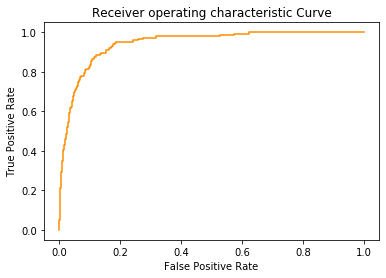

In [254]:
plt.plot(fpr,tpr,color='darkorange')
plt.title(plttitle)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Curve')